In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import sys
sys.path.append('../Utils/')


from compute_kernel import compute_mmd, compute_kernel_matrix,compute_witness_function
from compute_kernel import permutation_test_mmd, compute_p_values
from utils_other import  compute_diffusion_map, compute_dimension_reduction_wasskernel
%load_ext autoreload
%autoreload 2

In [3]:
data = np.loadtxt('../../shape_dynamics/Data/CellShape/breastcancer/cells.txt')

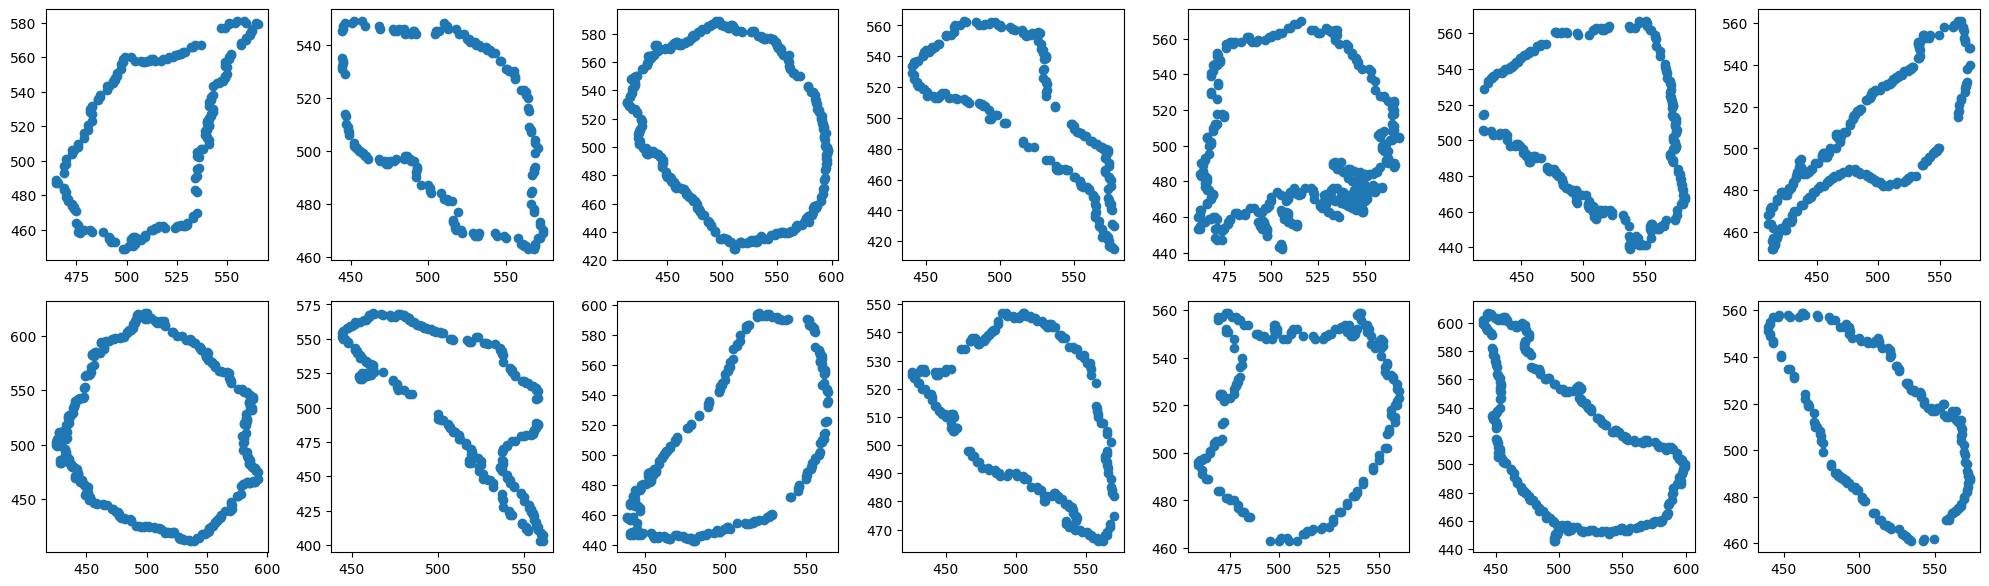

In [4]:
def read_file_and_split_into_arrays(file_path):
    # Read the file content
    with open(file_path, 'r') as file:
        data = file.read()

    # Split the data into blocks where each block is separated by blank lines
    blocks = [block.strip().split('\n') for block in data.split('\n\n') if block.strip()]

    # Convert each block into arrays of tuples (each row as a tuple of integers)
    arrays = [[tuple(map(int, line.split())) for line in block] for block in blocks]

    return arrays

# Example usage
file_path = '../../shape_dynamics/Data/CellShape/breastcancer/cells.txt'  # Replace with your file path
arrays = read_file_and_split_into_arrays(file_path)

plt.rcParams["figure.figsize"] = (20,6)
N_cells = 14
# To see a sample output
for i, array in enumerate(arrays[:N_cells], 1):
    # print(f"Array {i}: {array}\n")
    plt.subplot(2,N_cells//2,i)
    array = np.array( array )
    plt.scatter(array[:,0], array[:,1])
plt.tight_layout()
plt.show()

In [6]:
lines = []
with open('../../shape_dynamics/Data/CellShape/breastcancer/lines.txt') as f:
    lines = f.read().splitlines() 
all_lines = list( set(lines) )
all_lines = ['MCF10A','MCF7','MDA_MB_231']
idx_all = [0]*3
for i in range(3):
    idx_all[i] = []
for i in range(len(lines)):
    for j in range(3):
        if lines[i] == all_lines[j]:
            idx_all[j] += [i]


In [6]:
all_lines

['MCF10A', 'MCF7', 'MDA_MB_231']

In [7]:
for i in range(len(arrays)):
    arrays[i] = np.array(arrays[i])

In [ ]:
import time
start = time.time()
K_GW = compute_kernel_matrix(arrays,kernel_type='GW',normalize=True)
print(time.time()-start)

with open('K_GW_cell2', 'wb') as f:
    np.save(f, np.array(K_GW))   

In [72]:
import time
start = time.time()
K_W = compute_kernel_matrix(arrays,kernel_type='W_mine',normalize=True)
print(time.time()-start)

with open('K_Wasserstein_mine_cell2', 'wb') as f:
    np.save(f, np.array(K_W))    

677
100
1.3617987632751465


In [ ]:
import time
start = time.time()
K_Ws = compute_kernel_matrix(arrays,kernel_type='W_stratified',normalize=True)
print(time.time()-start)

with open('K_Wasserstein_stratified_cell2', 'wb') as f:
    np.save(f, np.array(K_Ws))    

In [36]:
from compute_kernel import mmd2_permutation
def compute_type_12(K_type, n_exp=500, method='MMD'):
    np.random.seed(0)
    if K_type == 'GW':
        K = np.load('../Results/K_GW.npy')
        K = np.sqrt(K)
    elif K_type == 'W_stratified':
        K = np.load('../Results/K_Wasserstein_stratified_cell2')
        # K = K ** 2
    
        # K = K ** 2
    elif K_type == 'W_mine':
        K = np.load('../Results/K_Wasserstein_mine_cell2')
        # K = K ** 2
    elif K_type == 'W_improved':
        K = np.load('../Results/K_Wasserstein_improved_cell2')
    elif K_type == 'SRV':
        K = np.load('../Results/SRV_metric_cell2_processed')

    # K = np.exp( -K/np.median(K))
    
    n_sample = [15,20,25,30,40,50,60]
    type_one_5 = [0]*len(n_sample)
    type_one_1 = [0]*len(n_sample)
    for n_id,n in enumerate(n_sample):
        p_all = np.zeros( (n_exp,1) )
        print(n_id)
        for j in range(len(p_all)):
            idx_part = np.random.permutation( len(idx_all[0]) )
            idx_part = [int(i) for i in idx_part]
            idx_part1 = [idx_all[0][idx_part[i]] for i in range(n) ] 
            idx_part2 = [idx_all[0][idx_part[i]] for i in range(n,2*n) ] 
            K_t = K[np.ix_(idx_part1+idx_part2, idx_part1+idx_part2)]
            # K_exp = np.exp( -K/np.median(K_t) )
            
            K_XX = K[np.ix_(idx_part1, idx_part1)]
            K_XX = np.exp(-K_XX/np.median(K_t) )
            K_XY = K[np.ix_(idx_part1, idx_part2)]
            K_XY = np.exp(-K_XY/np.median(K_t) )
            K_YY = K[np.ix_(idx_part2, idx_part2)]
            K_YY = np.exp(-K_YY/np.median(K_t) )
            # p_all[j], true_mmd, all_mmd = permutation_test_mmd(K_XX, K_YY, K_XY)
            #p_all[j] = compute_p_values(K_XX, K_YY, K_XY, method=method)
            if method == 'MMD':
                res = mmd2_permutation(np.exp(-K_t/np.median(K_t)), n)
            else:
                res = mmd2_permutation(-K_t, n)
            p_all[j] = res.p_value
        type_one_5[n_id] = np.sum( p_all < 0.05 )/len(p_all)
        type_one_1[n_id] = np.sum( p_all < 0.01 )/len(p_all)
        
    
    type_two_5 = [0]*len(n_sample)
    type_two_1 = [0]*len(n_sample)
    for n_id,n in enumerate(n_sample):
        p_all = np.zeros( (n_exp,1) )
        print(n_id)
        for j in range(len(p_all)):
            idx_part = np.random.permutation( 200 ) #len(idx_all[0]) )
            idx_part = [int(i) for i in idx_part]
            idx_part1 = [idx_all[0][idx_part[i]] for i in range(n) ] 
            idx_part = np.random.permutation( 200 )#len(idx_all[1]) )
            idx_part2 = [idx_all[1][idx_part[i]] for i in range(n) ] 
            K_t = K[np.ix_(idx_part1+idx_part2, idx_part1+idx_part2)]
            # K_exp = np.exp( -K/np.median(K_t) )
            
            
            K_XX = K[np.ix_(idx_part1, idx_part1)]
            K_XX = np.exp(-K_XX/np.median(K_t) )
            K_XY = K[np.ix_(idx_part1, idx_part2)]
            K_XY = np.exp(-K_XY/np.median(K_t) )
            K_YY = K[np.ix_(idx_part2, idx_part2)]
            K_YY = np.exp(-K_YY/np.median(K_t) )
            # p_all[j], true_mmd, all_mmd = permutation_test_mmd(K_XX, K_YY, K_XY)
            # p_all[j] = compute_p_values(K_XX, K_YY, K_XY, method=method)
            if method == 'MMD':
                res = mmd2_permutation(np.exp(-K_t/np.median(K_t)), n)
            else:
                res = mmd2_permutation(-K_t, n)
            p_all[j] = res.p_value
        type_two_5[n_id] = np.sum( p_all > 0.05 )/len(p_all)
        type_two_1[n_id] = np.sum( p_all > 0.01 )/len(p_all)
    
    
    plt.plot(n_sample, type_one_5,'ro-',label=r'Type I,$\alpha=5\%$')
    plt.plot(n_sample, type_one_1,'ro:',label=r'Type I,$\alpha=1\%$')
    
    plt.plot(n_sample, type_two_5,'bs-',label=r'Type II,$\alpha=5\%$')
    plt.plot(n_sample, type_two_1,'bs:',label=r'Type II,$\alpha=1\%$')
    
    # plt.ylim([0,0.3])
    plt.xlabel('Number of shapes')
    plt.legend()
    plt.show()
    return type_one_5, type_one_1, type_two_5, type_two_1

In [24]:
K_type = 'W_improved'
if K_type == 'GW':
    K = np.load('../../Scripts/K_all_breastcancercell.npy')
    K = np.sqrt(K)
elif K_type == 'W_stratified':
    K = np.load('K_Wasserstein_stratified_cell2')
        # K = K ** 2
elif K_type == 'W_block':
    K = np.load('K_Wasserstein_block_cell2')
        # K = K ** 2
elif K_type == 'W_mine':
    K = np.load('K_Wasserstein_mine_cell2')
        # K = K ** 2
elif K_type == 'W_improved':
    K = np.load('K_Wasserstein_improved_cell2')
    
K_t = K[np.ix_(idx_all[0]+idx_all[2], idx_all[0]+idx_all[2])]

res = mmd2_permutation(np.exp(-K_t/np.median(K_t)), len(idx_all[0]))
res.p_value

tensor(0.0020)

GW
0
1
2
3
4
5
6
0
1
2
3
4
5
6


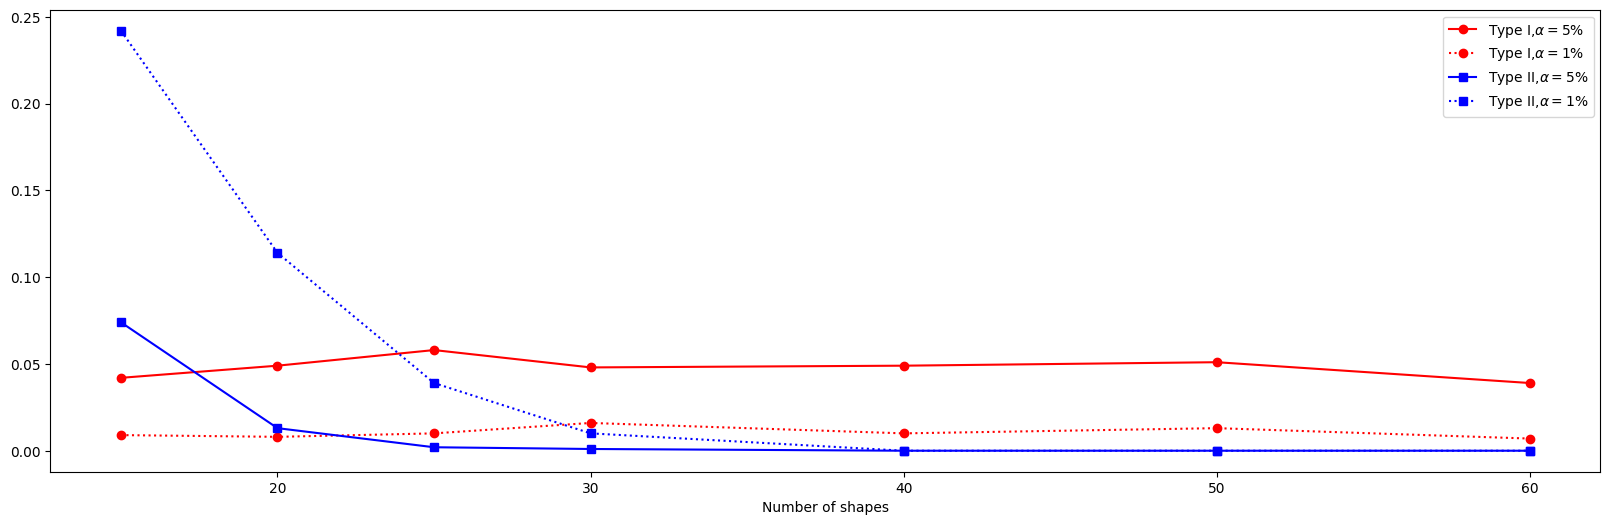

W_mine
0
1
2
3
4
5
6
0
1
2
3
4
5
6


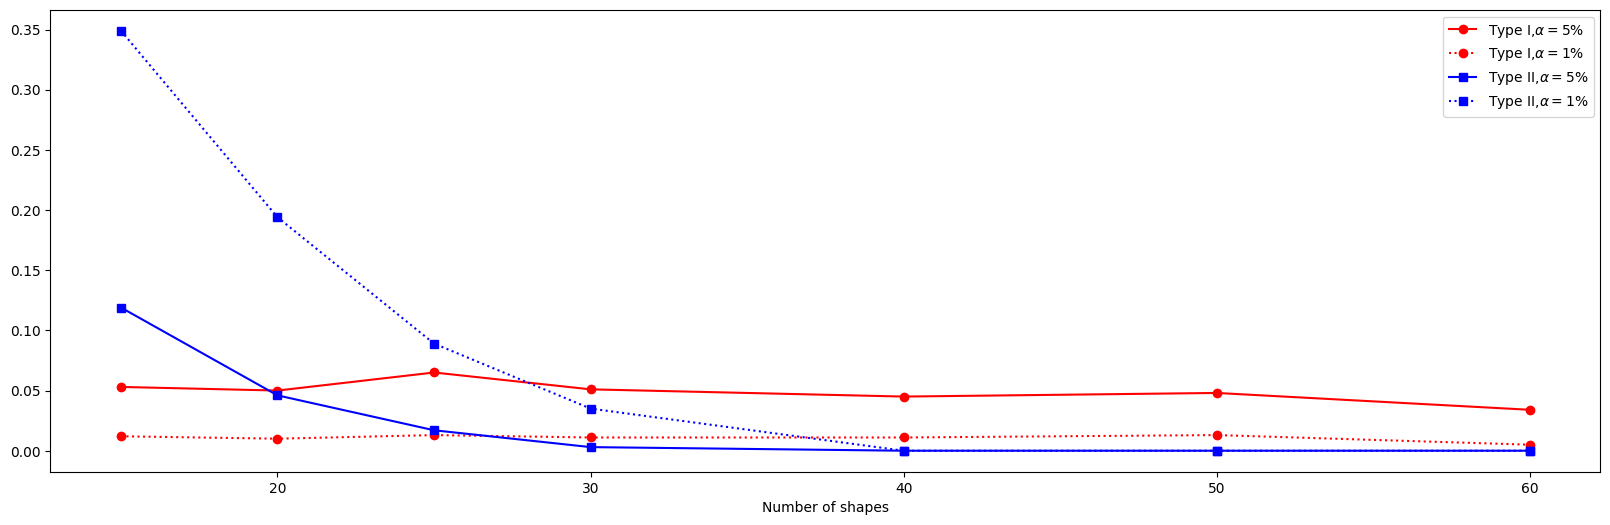

W_stratified
0
1
2
3
4
5
6
0
1
2
3
4
5
6


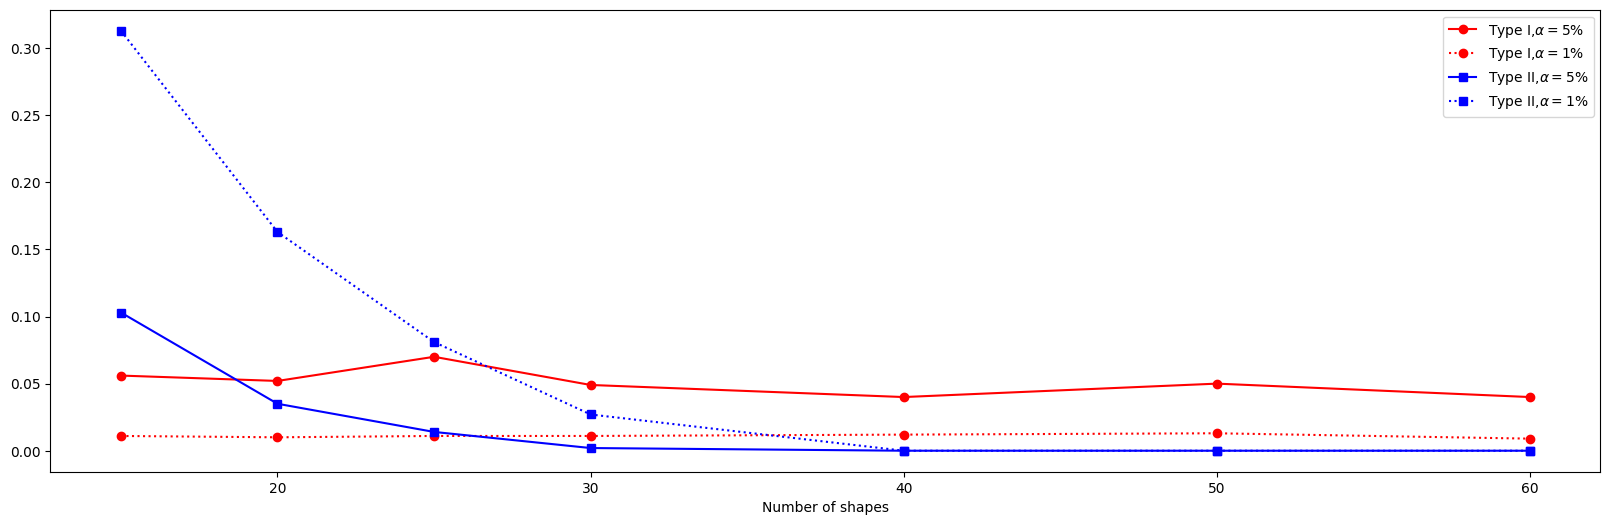

W_improved
0
1
2
3
4
5
6
0
1
2
3
4
5
6


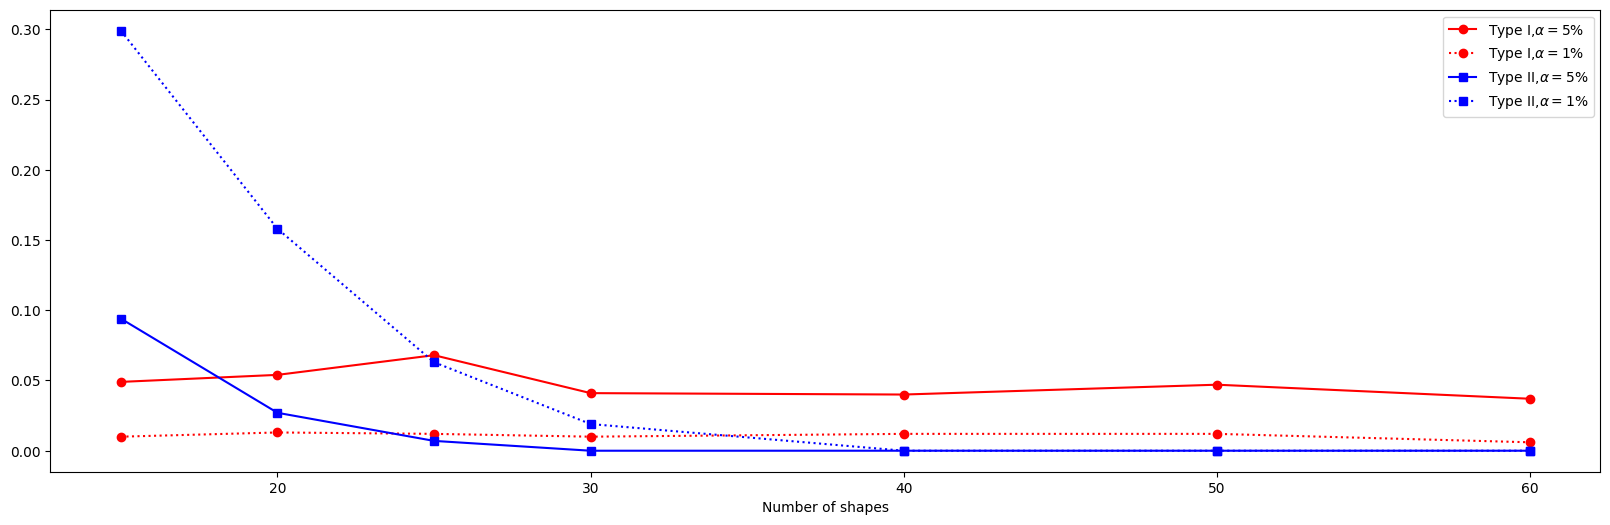

SRV
0
1
2
3
4
5
6
0
1
2
3
4
5
6


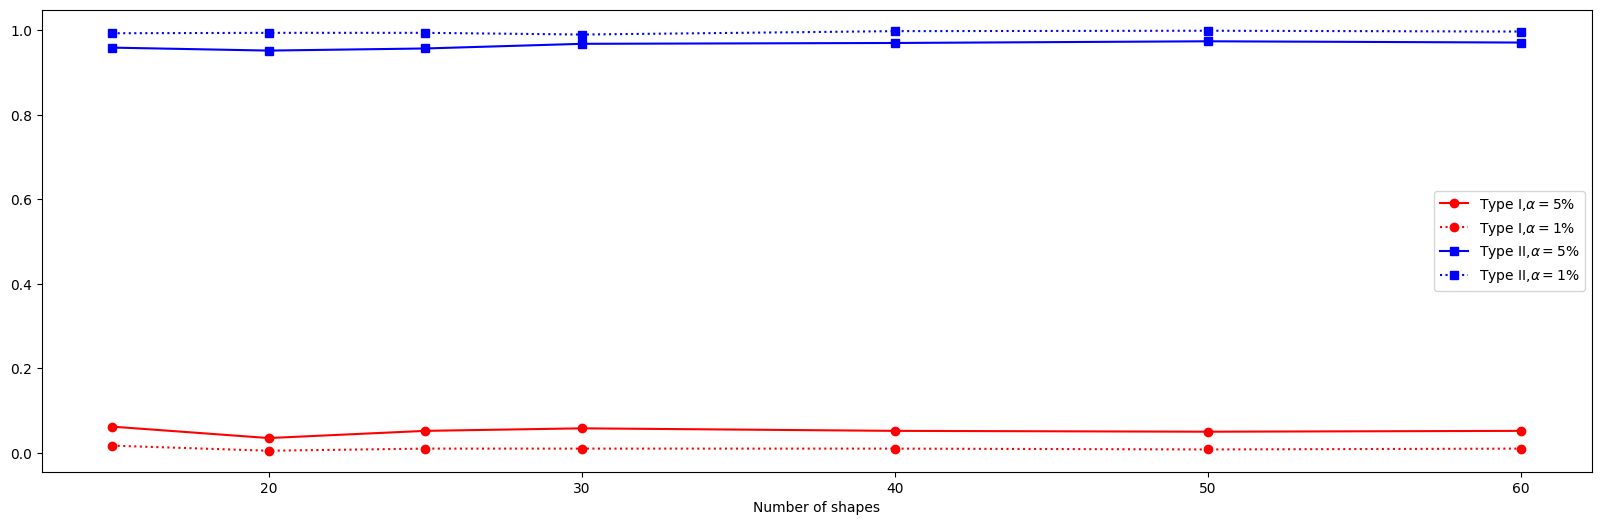

ELASTIC
0
1
2
3
4
5
6
0
1
2
3
4
5
6


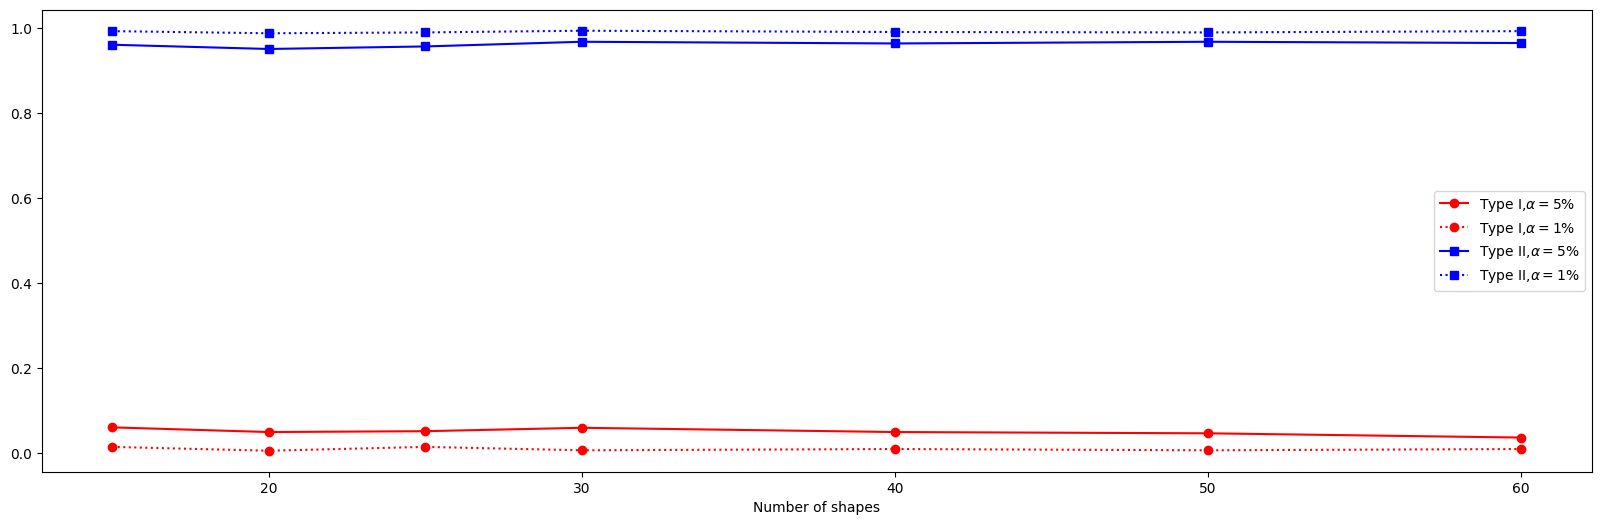

W_block
0
1
2
3
4
5
6
0
1
2
3
4
5
6


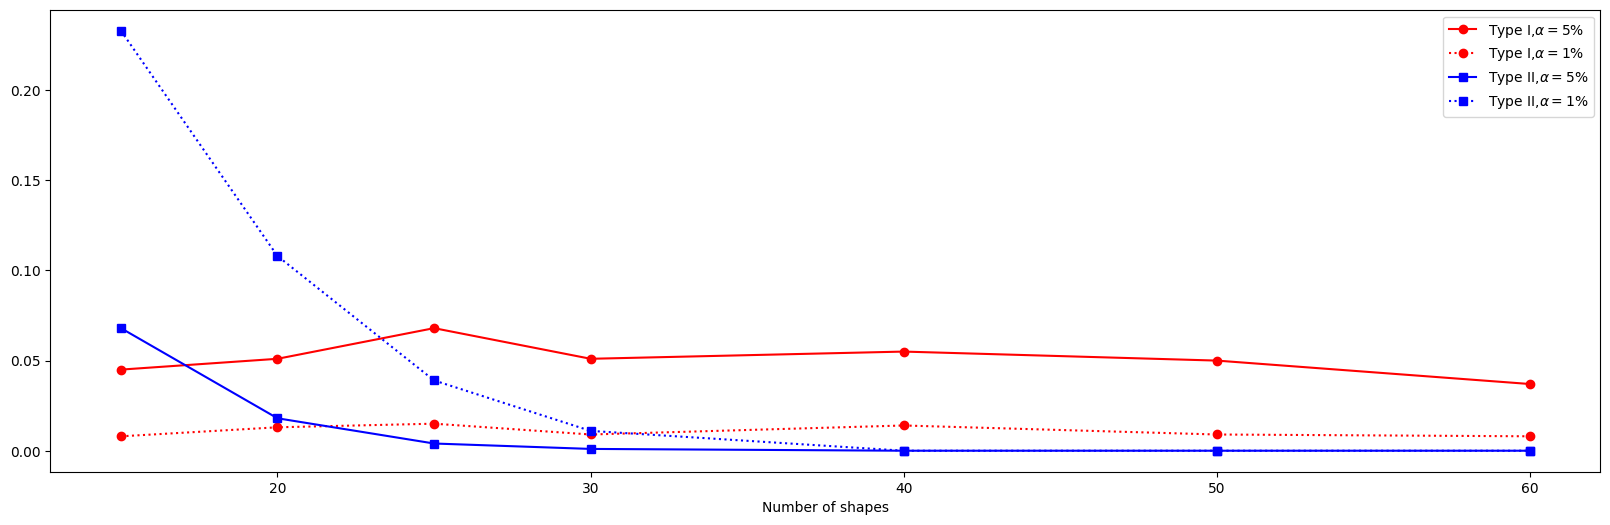

In [37]:
K_types = ['GW','W_mine','W_stratified','W_improved','SRV','ELASTIC','W_block']
type_one_5 = [0]*len(K_types)
type_one_1 = [0]*len(K_types)
type_two_5 = [0]*len(K_types)
type_two_1 = [0]*len(K_types)

for i,K_type in enumerate(K_types):
    print(K_type)
    type_one_5[i], type_one_1[i], type_two_5[i], type_two_1[i] = compute_type_12(K_type = K_type, n_exp=1000, method='energy')

In [38]:
np.save('type_one_5_cell2_energy.npy',type_one_5)
np.save('type_one_1_cell2_energy.npy',type_one_1)
np.save('type_two_5_cell2_energy.npy',type_two_5)
np.save('type_two_1_cell2_energy.npy',type_two_1)

Text(0.5, 0, 'Number of shapes')

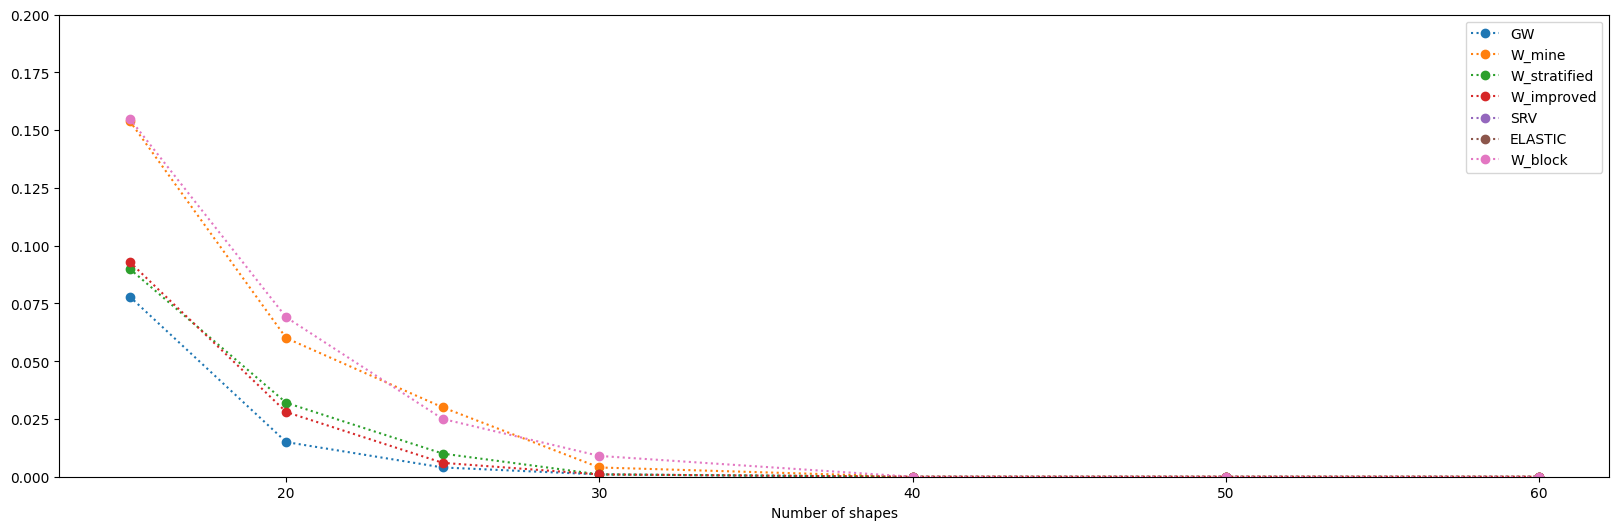

In [27]:
for i in range(len(K_types)):
    plt.plot([15,20,25,30,40,50,60],type_two_5[i],':o',label=K_types[i])
plt.ylim([0,0.2])
plt.legend()
plt.xlabel('Number of shapes')

Text(0.5, 0, 'Number of shapes')

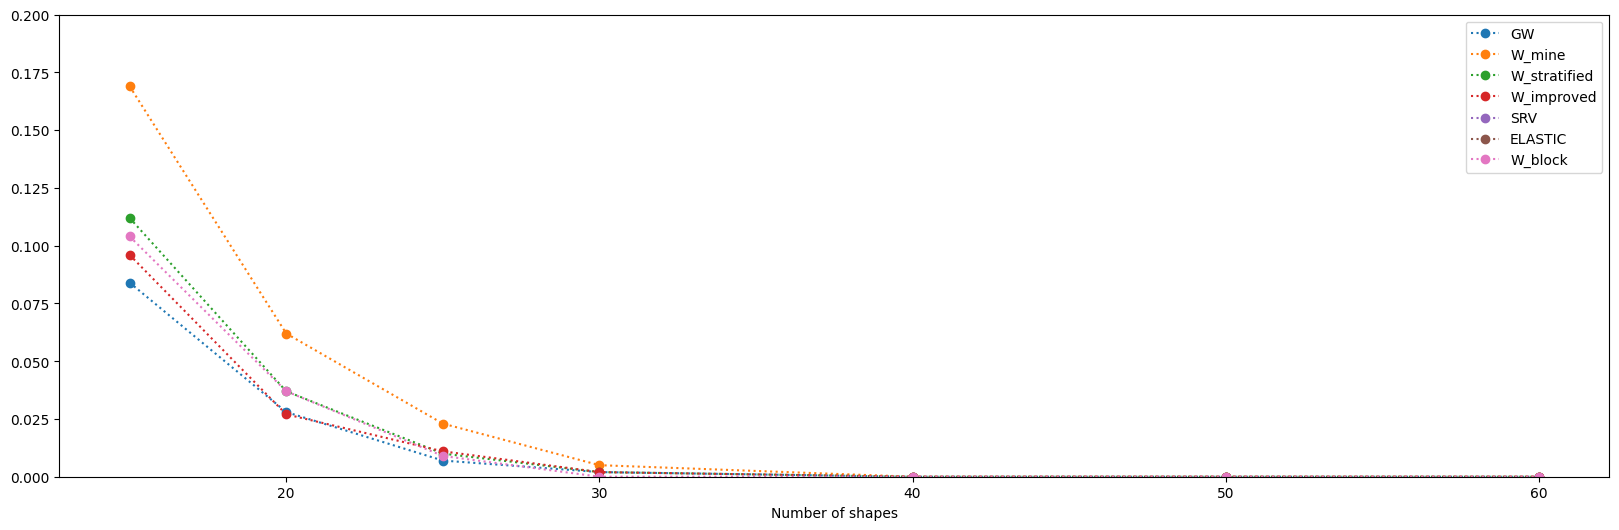

In [15]:
for i in range(len(K_types)):
    plt.plot([15,20,25,30,40,50,60],type_two_5[i],':o',label=K_types[i])
plt.ylim([0,0.2])
plt.legend()
plt.xlabel('Number of shapes')

Text(0.5, 1.0, '216.60709010339735')

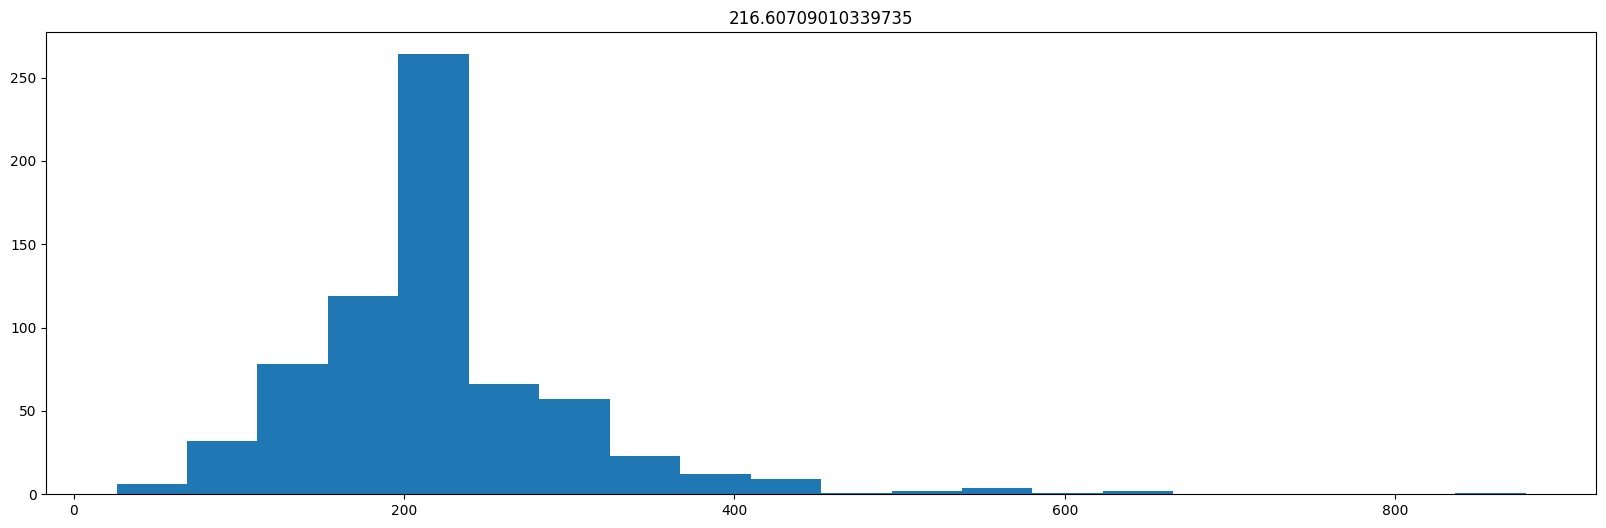

In [21]:
n_pts = [0]*len(arrays)
for i in range(len(arrays)):
    n_pts[i] = arrays[i].shape[0]
plt.hist(n_pts,20)
plt.title(np.mean(n_pts))

[  6  32  35  42  66  70  73  84  97 100 102 111 114 119 127 142 167 173
 183 186 194 213 218]


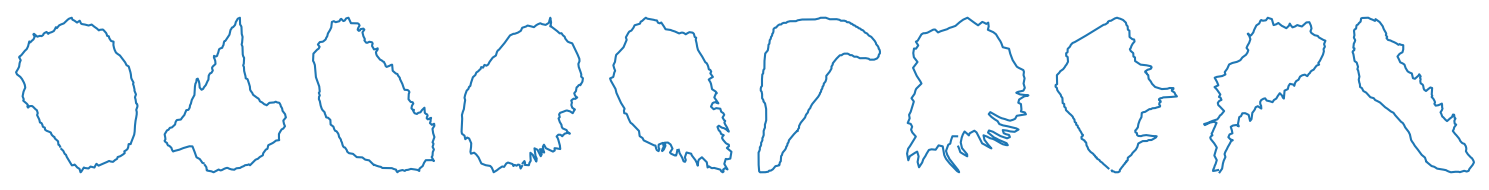

In [28]:
plt.figure(figsize=(15, 2))
K = np.load('K_Wasserstein_stratified_cell2')
K = np.load('K_Wasserstein_block_cell2')
# K = np.load('K_Wasserstein_mine_cell2')
K = np.exp(-K/np.median(K))
K_XX = K[np.ix_(idx_all[0], idx_all[0])]
K_XY = K[np.ix_(idx_all[0], idx_all[1])]
K_YY = K[np.ix_(idx_all[1], idx_all[1])]

witness_values = [0]*len(idx_all[0])
for i in range(len(idx_all[0])):
    
    witness_values[i] = compute_witness_function(i, K_XX, K_XY)

idx_max = np.where( np.array(witness_values) > np.quantile(witness_values,0.9) )[0]
print(idx_max)
idx_max = [idx_all[0][i] for i in idx_max]
for i in range(10):
    plt.subplot(1,10,i+1)
    idx_max = np.where( (np.array(witness_values) > np.quantile(witness_values,0.1*i+0.04)) & (np.array(witness_values) < np.quantile(witness_values,0.1*i+0.06)) )[0][0]
    idx_max = idx_all[0][idx_max]
    plt.plot(arrays[idx_max][:,0], arrays[idx_max][:,1])
    plt.axis('off')
    # plt.title(str(10*i+5))
plt.tight_layout()
# plt.savefig('Figures/cells_ranked.png')
plt.show()

In [28]:
from compute_kernel import mmd2_permutation
def compute_type_12(K_type, n_exp=500, method='gamma'):
    np.random.seed(0)
    if K_type == 'GW':
        K = np.load('../../Scripts/K_all_breastcancercell.npy')
        K = np.sqrt(K)
    elif K_type == 'W_stratified':
        K = np.load('K_Wasserstein_stratified_newscore_cell2')
        # K = K ** 2
    elif K_type == 'W_block':
        K = np.load('K_Wasserstein_block_newscore_cell2')
        # K = K ** 2
    elif K_type == 'W_mine':
        K = np.load('K_Wasserstein_mine_cell2')
        # K = K ** 2
    elif K_type == 'W_improved':
        K = np.load('K_Wasserstein_improved_cell2')
    elif K_type == 'SRV':
        K = np.load('SRV_metric_cell2_processed')
    elif K_type == 'ELASTIC':
        K = np.load('ELASTIC_metric_cell2_processed')
    # K = np.exp( -K/np.median(K))
        
    n_sample = [15,20,25,30,40,50,60]
    type_one_5 = [0]*len(n_sample)
    type_one_1 = [0]*len(n_sample)
    for n_id,n in enumerate(n_sample):
        p_all = np.zeros( (n_exp,1) )
        print(n_id)
        for j in range(len(p_all)):
            # MMD(1,3) = MMD(2,3)
            idx_part = np.random.permutation(200)# len(idx_all[0]) )
            idx_part = [int(i) for i in idx_part]
            idx_part1 = [idx_all[0][idx_part[i]] for i in range(n) ] 
            idx_part2 = [idx_all[0][idx_part[i]] for i in range(n,2*n) ]
            idx_part3 = [idx_all[0][idx_part[i]] for i in range(2*n,3*n) ] 
            K_t = K[np.ix_(idx_part1+idx_part3, idx_part1+idx_part3)]
            # K_exp = np.exp( -K/np.median(K_t) )
            
            K_XX = K[np.ix_(idx_part1, idx_part1)]
            K_XX = np.exp(-K_XX/np.median(K_t) )
            K_XY = K[np.ix_(idx_part1, idx_part3)]
            K_XY = np.exp(-K_XY/np.median(K_t) )
            K_YY = K[np.ix_(idx_part3, idx_part3)]
            K_YY = np.exp(-K_YY/np.median(K_t) )

            # p_all[j], true_mmd, all_mmd = permutation_test_mmd(K_XX, K_YY, K_XY)
            #p_all[j] = compute_p_values(K_XX, K_YY, K_XY, method=method)
            res1 = mmd2_permutation(np.exp(-K_t/np.median(K_t)), n)

            K_XX = K[np.ix_(idx_part2, idx_part2)]
            K_XX = np.exp(-K_XX/np.median(K_t) )
            K_XY = K[np.ix_(idx_part2, idx_part3)]
            K_XY = np.exp(-K_XY/np.median(K_t) )
            K_YY = K[np.ix_(idx_part3, idx_part3)]
            K_YY = np.exp(-K_YY/np.median(K_t) )
            K_t = K[np.ix_(idx_part2+idx_part3, idx_part2+idx_part3)]
            # p_all[j], true_mmd, all_mmd = permutation_test_mmd(K_XX, K_YY, K_XY)
            #p_all[j] = compute_p_values(K_XX, K_YY, K_XY, method=method)
            res2 = mmd2_permutation(np.exp(-K_t/np.median(K_t)), n)
            t = res1.permuted_estimates - res2.permuted_estimates
            t = t.detach().numpy()
            t_obs = res1.estimate - res2.estimate
            t_obs = t_obs.detach().numpy()
            # print(res1)



            p_all[j] = (1 + np.sum( t >= t_obs)) / (len(t) + 1)
        type_one_5[n_id] = np.sum( p_all < 0.05 )/len(p_all)
        type_one_1[n_id] = np.sum( p_all < 0.01 )/len(p_all)
    type_two_5 = [0]*len(n_sample)
    type_two_1 = [0]*len(n_sample)
    for n_id,n in enumerate(n_sample):
        p_all = np.zeros( (n_exp,1) )
        print(n_id)
        for j in range(len(p_all)):
            # MMD(1,3) = MMD(2,3) # 10, 7, 231
            idx_part = np.random.permutation(200)# len(idx_all[0]) )
            idx_part = [int(i) for i in idx_part]
            idx_part1 = [idx_all[1][idx_part[i]] for i in range(n) ] 
            idx_part2 = [idx_all[0][idx_part[i]] for i in range(n) ]
            idx_part3 = [idx_all[0][idx_part[i]] for i in range(n,2*n) ] 
            K_t = K[np.ix_(idx_part1+idx_part3, idx_part1+idx_part3)]
            # K_exp = np.exp( -K/np.median(K_t) )
            
            K_XX = K[np.ix_(idx_part1, idx_part1)]
            K_XX = np.exp(-K_XX/np.median(K_t) )
            K_XY = K[np.ix_(idx_part1, idx_part3)]
            K_XY = np.exp(-K_XY/np.median(K_t) )
            K_YY = K[np.ix_(idx_part3, idx_part3)]
            K_YY = np.exp(-K_YY/np.median(K_t) )

            # p_all[j], true_mmd, all_mmd = permutation_test_mmd(K_XX, K_YY, K_XY)
            #p_all[j] = compute_p_values(K_XX, K_YY, K_XY, method=method)
            res1 = mmd2_permutation(np.exp(-K_t/np.median(K_t)), n)

            K_XX = K[np.ix_(idx_part2, idx_part2)]
            K_XX = np.exp(-K_XX/np.median(K_t) )
            K_XY = K[np.ix_(idx_part2, idx_part3)]
            K_XY = np.exp(-K_XY/np.median(K_t) )
            K_YY = K[np.ix_(idx_part3, idx_part3)]
            K_YY = np.exp(-K_YY/np.median(K_t) )
            K_t = K[np.ix_(idx_part2+idx_part3, idx_part2+idx_part3)]
            # p_all[j], true_mmd, all_mmd = permutation_test_mmd(K_XX, K_YY, K_XY)
            #p_all[j] = compute_p_values(K_XX, K_YY, K_XY, method=method)
            res2 = mmd2_permutation(np.exp(-K_t/np.median(K_t)), n)
            t = res1.permuted_estimates - res2.permuted_estimates
            t = t.detach().numpy()
            t_obs = res1.estimate - res2.estimate
            t_obs = t_obs.detach().numpy()
            p_all[j] = (1 + np.sum( t >= t_obs)) / (len(t) + 1)
            # print(res1)
        type_two_5[n_id] = np.sum( p_all > 0.05 )/len(p_all)
        type_two_1[n_id] = np.sum( p_all > 0.01 )/len(p_all)
    
    
    plt.plot(n_sample, type_one_5,'ro-',label=r'Type I,$\alpha=5\%$')
    plt.plot(n_sample, type_one_1,'ro:',label=r'Type I,$\alpha=1\%$')
    
    plt.plot(n_sample, type_two_5,'bs-',label=r'Type II,$\alpha=5\%$')
    plt.plot(n_sample, type_two_1,'bs:',label=r'Type II,$\alpha=1\%$')
    
    # plt.ylim([0,0.3])
    plt.xlabel('Number of shapes')
    plt.legend()
    plt.show()
    return type_one_5, type_one_1, type_two_5, type_two_1

GW
0
1
2
3
4
5
6
0
1
2
3
4
5
6


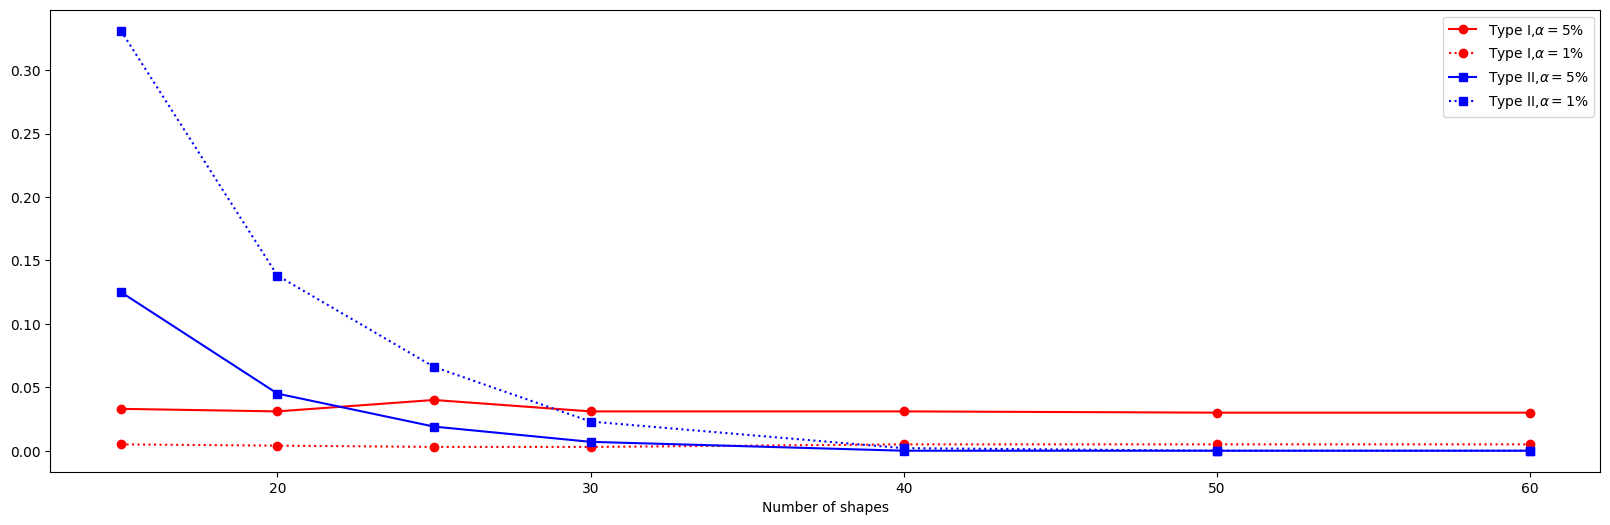

W_mine
0
1
2
3
4
5
6
0
1
2
3
4
5
6


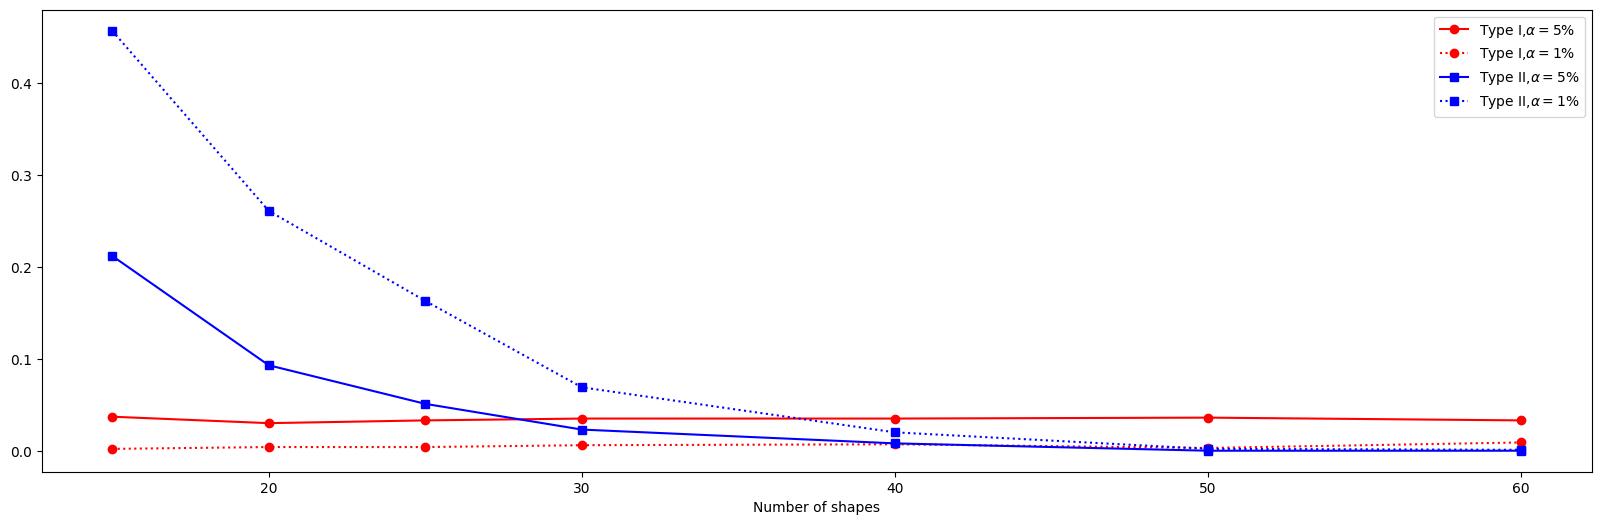

W_stratified
0
1
2
3
4
5
6
0
1
2
3
4
5
6


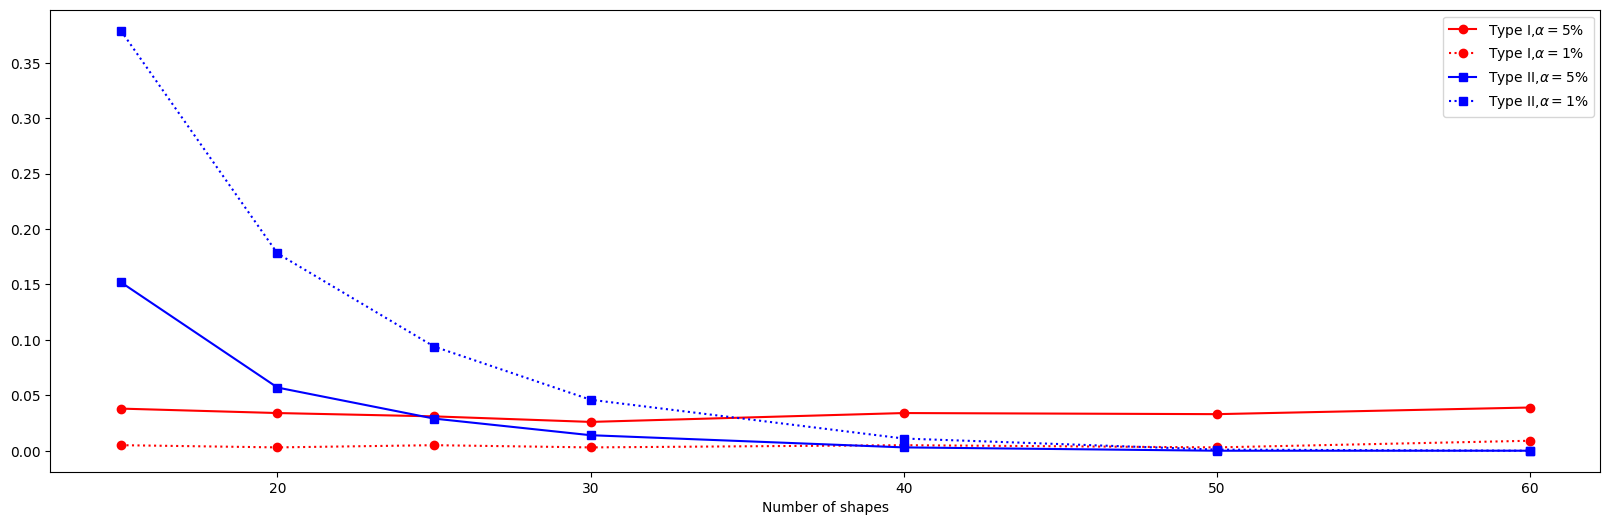

W_improved
0
1
2
3
4
5
6
0
1
2
3
4
5
6


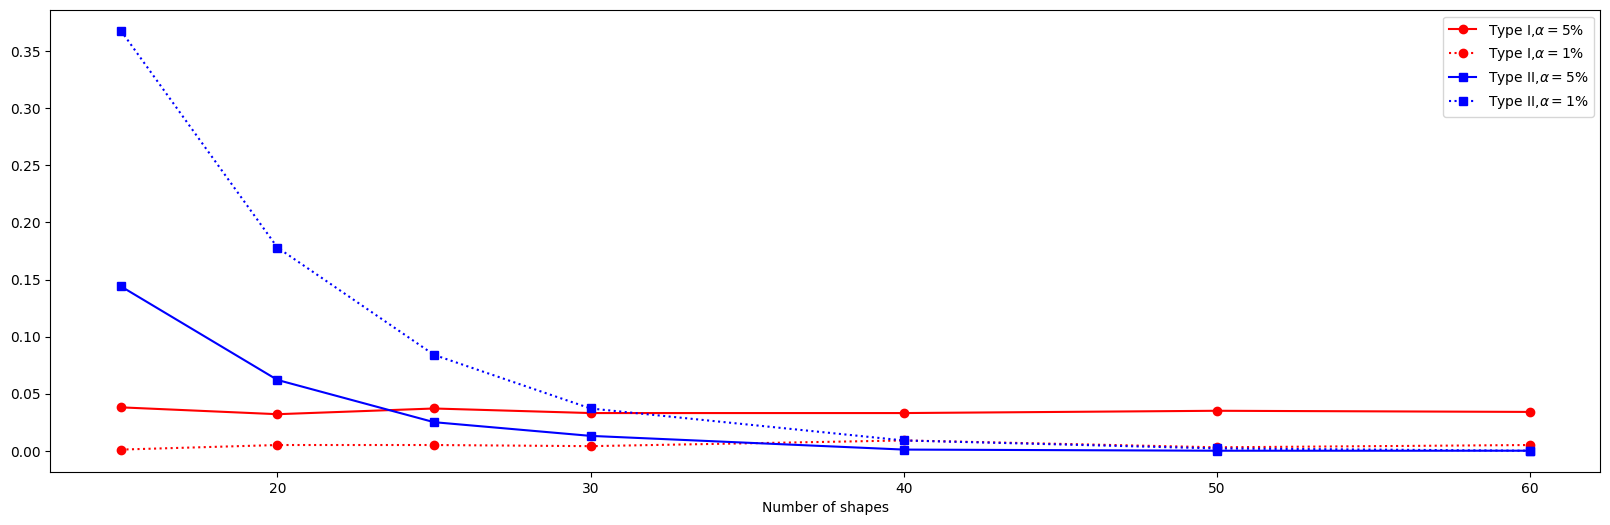

SRV
0
1
2
3
4
5
6
0
1
2
3
4
5
6


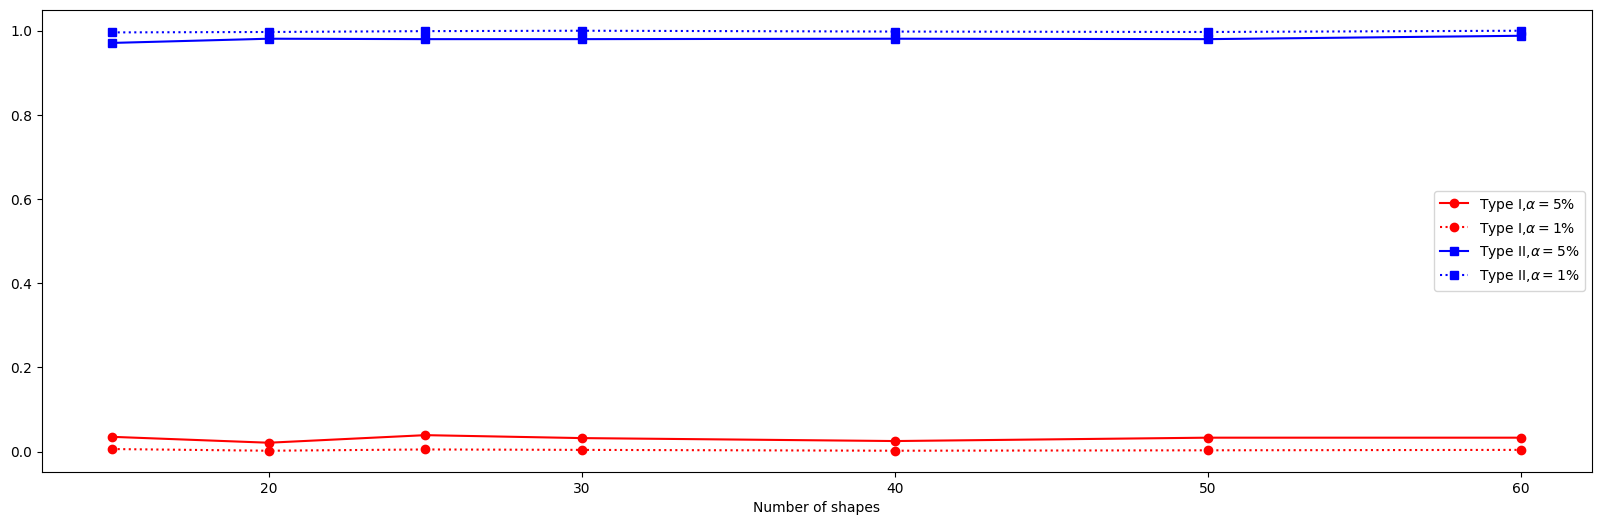

ELASTIC
0
1
2
3
4
5
6
0
1
2
3
4
5
6


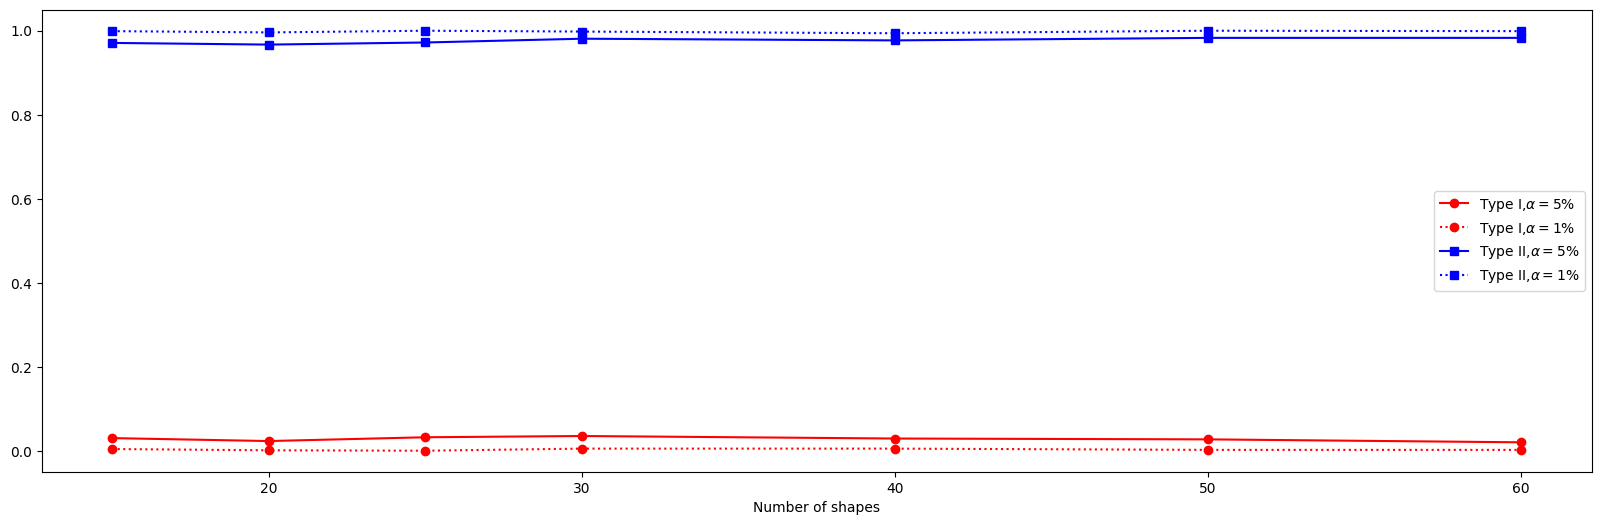

W_block
0
1
2
3
4
5
6
0
1
2
3
4
5
6


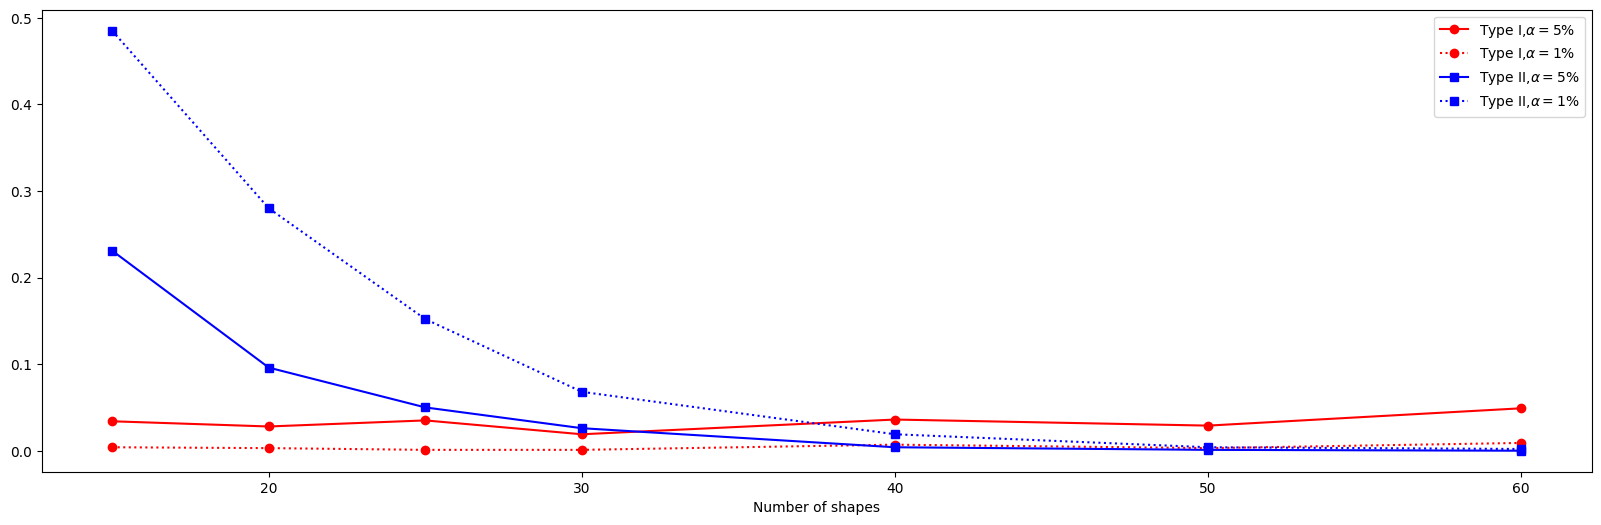

In [29]:
K_types = ['GW','W_mine','W_stratified','W_improved','SRV','ELASTIC','W_block']
type_one_5 = [0]*len(K_types)
type_one_1 = [0]*len(K_types)
type_two_5 = [0]*len(K_types)
type_two_1 = [0]*len(K_types)

for i,K_type in enumerate(K_types):
    print(K_type)
    type_one_5[i], type_one_1[i], type_two_5[i], type_two_1[i] = compute_type_12(K_type = K_type, n_exp=1000, method='permutation')

In [31]:
np.save('type_one_5_cell2_3sample.npy',type_one_5)
np.save('type_one_1_cell2_3sample.npy',type_one_1)
np.save('type_two_5_cell2_3sample.npy',type_two_5)
np.save('type_two_1_cell2_3sample.npy',type_two_1)

In [19]:
len(idx_all[2])

224

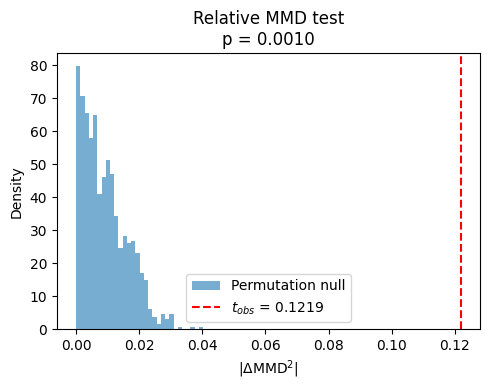

Two-sided p-value: 0.0010


In [32]:
import numpy as np
import matplotlib.pyplot as plt

# Original indices
idx_10A = idx_all[0]
idx_7 = idx_all[1]
idx_mda = idx_all[2]

# Sample sizes
n1 = len(idx_10A)
n2 = len(idx_7)
n = min(n1, n2)  # Use same size if they differ (optional for fairness)
B = 1000  # Number of permutations

# Subsample to equal sizes (if needed)
idx_10A = idx_10A[:n]
idx_7 = idx_7[:n]

# Combine 10A and 7
idx_pool = idx_10A + idx_7
Z = idx_mda[:n]  # Sample MDA to match

# Compute observed t
def compute_mmd2_from_kernel(K, X, Y):
    K_XX = K[np.ix_(X, X)]
    K_XY = K[np.ix_(X, Y)]
    K_YY = K[np.ix_(Y, Y)]
    return (
        K_XX.mean() + K_YY.mean() - 2 * K_XY.mean()
    )

K_exp = np.exp(-K / np.median(K))

mmd_7 = compute_mmd2_from_kernel(K_exp, idx_7, Z)
mmd_10A = compute_mmd2_from_kernel(K_exp, idx_10A, Z)
t_obs = mmd_7 - mmd_10A

# Permutation null
perm_stats = []
for _ in range(B):
    perm = np.random.permutation(idx_pool)
    A = perm[:n]
    B_ = perm[n:]
    mmd_A = compute_mmd2_from_kernel(K_exp, A, Z)
    mmd_B = compute_mmd2_from_kernel(K_exp, B_, Z)
    perm_stats.append(mmd_A - mmd_B)

# Compute p-value
perm_stats = np.array(perm_stats)
p = (1 + np.sum(np.abs(perm_stats) >= np.abs(t_obs))) / (B + 1)

# Plot
plt.figure(figsize=(5, 4))
plt.hist(np.abs(perm_stats), bins=30, density=True, alpha=0.6, label="Permutation null")
plt.axvline(np.abs(t_obs), color='red', linestyle='--', label=f"$t_{{obs}}$ = {t_obs:.4f}")
plt.xlabel(r"$|\Delta \mathrm{MMD}^2|$")
plt.ylabel("Density")
plt.title(f"Relative MMD test\np = {p:.4f}")
plt.legend()
plt.tight_layout()
plt.savefig('Figures/p-value-relative.png')
plt.show()

print(f"Two-sided p-value: {p:.4f}")


In [96]:
all_lines

['MCF10A', 'MCF7', 'MDA_MB_231']

In [118]:
K_t = K[np.ix_(idx_all[1] + idx_all[2], idx_all[1] + idx_all[2])] # two cancer lines
res1 = mmd2_permutation(np.exp(-K_t/np.median(K_t)), len(idx_all[1]))#,n_perm=1000)
res1.estimate

tensor(0.1409, dtype=torch.float64)

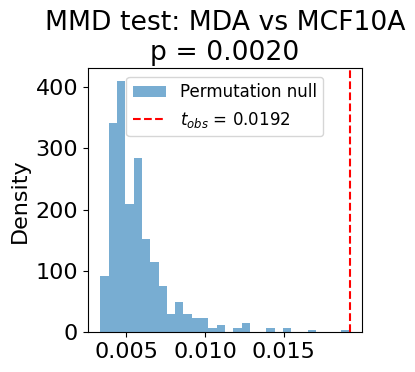

In [10]:
plt.rcParams['font.size']=16
from compute_kernel import mmd2_permutation
K = np.load('K_Wasserstein_stratified_cell2')

K_t = K[np.ix_(idx_all[0] + idx_all[2], idx_all[0] + idx_all[2])] # two cancer lines
res1 = mmd2_permutation(np.exp(-K_t/np.median(K_t)), len(idx_all[0]))#,n_perm=1000)
res1.estimate

plt.figure(figsize=(4,4))
plt.hist(res1.permuted_estimates, bins=30, density=True, alpha=0.6, label="Permutation null")
plt.axvline(res1.estimate, color='red', linestyle='--', label=f"$t_{{obs}}$ = {res1.estimate:.4f}")
# plt.xlabel(r"$t = \mathrm{MMD}^2(MCF10A,MDA)$")
plt.ylabel("Density")
plt.title(f"MMD test: MDA vs MCF10A\np = {res1.p_value:.4f}")
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('Figures/p-value-absolute.png')
plt.show()
